Failed to load model from best_model_V2.pth: 'collections.OrderedDict' object has no attribute 'eval'


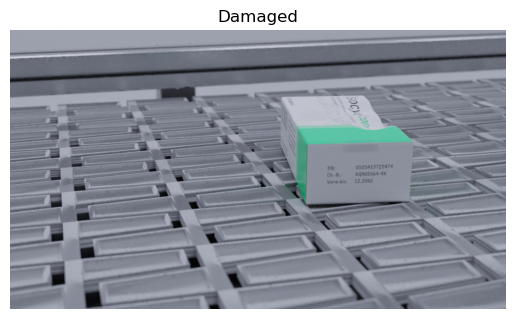

Predictions for archive/damaged/side/0105413725474_side.png:
  ResNet50_V1: Intact
  EfficientNet: Intact
  DenseNet: Intact
  VGG: Intact
  GoogleViT: Intact

------------------------------------------------------------



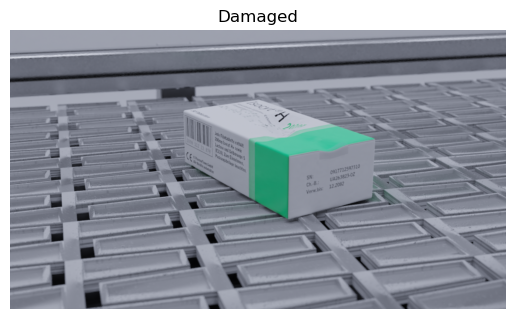

Predictions for archive/damaged/side/0917712597310_side.png:
  ResNet50_V1: Intact
  EfficientNet: Intact
  DenseNet: Intact
  VGG: Intact
  GoogleViT: Intact

------------------------------------------------------------



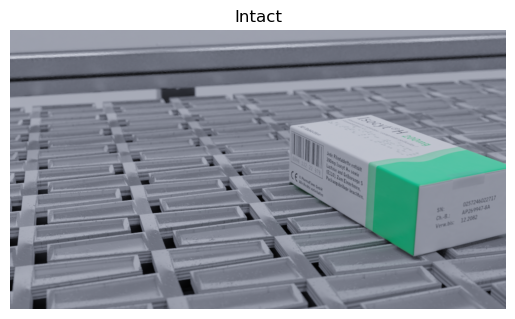

Predictions for archive/intact/side/0257246022717_side.png:
  ResNet50_V1: Intact
  EfficientNet: Damaged
  DenseNet: Damaged
  VGG: Intact
  GoogleViT: Intact

------------------------------------------------------------



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation results for ResNet50_V1:
Confusion matrix:
[[44  0]
 [36  0]]
Accuracy: 0.5500
F1 score: 0.0000
Recall: 0.0000
Precision: 0.0000


Evaluation results for EfficientNet:
Confusion matrix:
[[39  5]
 [ 7 29]]
Accuracy: 0.8500
F1 score: 0.8286
Recall: 0.8056
Precision: 0.8529


Evaluation results for DenseNet:
Confusion matrix:
[[41  3]
 [ 2 34]]
Accuracy: 0.9375
F1 score: 0.9315
Recall: 0.9444
Precision: 0.9189


Evaluation results for VGG:
Confusion matrix:
[[44  0]
 [36  0]]
Accuracy: 0.5500
F1 score: 0.0000
Recall: 0.0000
Precision: 0.0000


Evaluation results for GoogleViT:
Confusion matrix:
[[44  0]
 [36  0]]
Accuracy: 0.5500
F1 score: 0.0000
Recall: 0.0000
Precision: 0.0000


Results saved to results.txt


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
import torch
from transformers import ViTForImageClassification
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader, random_split  

# Function to load the entire model object
def load_model(model_path):
    try:
        model = torch.load(model_path)
        model.eval()
        return model
    except Exception as e:
        print(f"Failed to load model from {model_path}: {e}")
        return None

# transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_image(img_path):
    image = Image.open(img_path)
    return transform(image).unsqueeze(0)

# create a test dataset
test_data = datasets.ImageFolder(root="archive", transform=transform)
test_data_loader = DataLoader(test_data, batch_size=32, shuffle=False)
test_data_size = len(test_data)

 

# Load the pretrained models
model_paths = {
    "ResNet50_V1": "best_model_V1.pth",
    "ResNet50_V2": "best_model_V2.pth",
    "EfficientNet": "best_model_V3.pth",
    "DenseNet": "best_model_V4.pth",
    "VGG": "best_model_V5.pth",
    "GoogleViT": "best_model_V6.pth"
}

models_dict = {}
for model_name, model_path in model_paths.items():
    model = load_model(model_path)
    if model is not None:
        models_dict[model_name] = model

# Function to test a model on an image
def test_model(model, img_tensor, device):
    img_tensor = img_tensor.to(device)
    model = model.to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
        if isinstance(outputs, dict) and 'logits' in outputs:  # For ViT model
            outputs = outputs['logits']
        _, preds = torch.max(outputs, 1)
    return preds.item()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sample_image_paths = [
    "archive/damaged/side/0105413725474_side.png",
    "archive/damaged/side/0917712597310_side.png",
    "archive/intact/side/0257246022717_side.png"
]

# Test the models on each sample image and display the results
for sample_image_path in sample_image_paths:
    img_tensor = load_image(sample_image_path)
    
    predictions = {}
    for model_name, model in models_dict.items():
        pred = test_model(model, img_tensor, device)
        predictions[model_name] = pred
    
    # Display the sample image
    plt.imshow(Image.open(sample_image_path))
    # title = "Intact" if "intact" in sample_image_path else "Damaged" 
    # also show true label
    title = "Intact" if "intact" in sample_image_path else "Damaged"
    plt.title(title)

    plt.axis("off")
    plt.show()
    
    # Print predictions for each model
    print(f"Predictions for {sample_image_path}:")
    for model_name, pred in predictions.items():
        print(f"  {model_name}: {'Intact' if pred == 0 else 'Damaged'}")
    print("\n" + "-"*60 + "\n")


from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

# evaluate a model on the test set
def evaluate_model(model, test_loader, device):
    model = model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            if isinstance(outputs, dict) and 'logits' in outputs:  # For ViT model
                outputs = outputs['logits']
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Evaluate each model
results = {}
for model_name, model in models_dict.items():
    preds, labels = evaluate_model(model, test_loader, device)
    results[model_name] = {
        "confusion_matrix": confusion_matrix(labels, preds),
        "accuracy": accuracy_score(labels, preds),
        "f1_score": f1_score(labels, preds),
        "recall": recall_score(labels, preds),
        "precision": precision_score(labels, preds)
    }

# Print evaluation results
for model_name, metrics in results.items():
    print(f"Evaluation results for {model_name}:")
    print(f"Confusion matrix:\n{metrics['confusion_matrix']}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 score: {metrics['f1_score']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print("\n")

# Save the results to a file
with open("results.txt", "w") as f:
    for model_name, metrics in results.items():
        f.write(f"Evaluation results for {model_name}:\n")
        f.write(f"Confusion matrix:\n{metrics['confusion_matrix']}\n")
        f.write(f"Accuracy: {metrics['accuracy']:.4f}\n")
        f.write(f"F1 score: {metrics['f1_score']:.4f}\n")
        f.write(f"Recall: {metrics['recall']:.4f}\n")
        f.write(f"Precision: {metrics['precision']:.4f}\n\n")

print("Results saved to results.txt")

